In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/zeya/Git/kth-machine_learning/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python",project="airqualitypredictionssr")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-25 20:22:49,378 INFO: Initializing external client
2025-11-25 20:22:49,378 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-25 20:22:50,852 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279183


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city','date'])

df_preview = selected_features.read()
df_preview.head()

2025-11-25 20:22:53,181 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (101.33s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,11.0,2017-12-01 00:00:00+00:00,18.673666,0.0,19.829433,100.257843
1,20.0,2018-01-02 00:00:00+00:00,32.677834,0.0,27.887802,92.115875
2,19.0,2018-01-10 00:00:00+00:00,26.827835,1.0,21.068459,359.999878
3,17.0,2018-02-05 00:00:00+00:00,29.952837,0.0,25.570139,115.702568
4,17.0,2018-03-03 00:00:00+00:00,19.515333,0.0,25.984919,116.075294


In [6]:
# just to cocnfirm if we have the right format

df = selected_features.read()  #
print("rows:", len(df))


uniq = df.groupby(['date']).size().sort_values(ascending=False).head(10)
print(uniq)  # 若出现 >1 的计数，说明按 city 的 join 发生了倍增

df2 = (
    air_quality_fg.select(['pm25','date','city'])
    .join(weather_fg.select_features(), on=['city','date'])
).read()
dup = df2.groupby(['city','date']).size().sort_values(ascending=False).head(10)
print(dup)

2025-11-25 20:25:37,087 ERROR: Peer airqualitypredictionssr__zeyashen is not known. Please register client certificates first.. Detail: Python exception: Traceback (most recent call last):
  File "/usr/src/app/src/server.py", line 142, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/src/app/src/server.py", line 165, in wrapper
    instance._set_peer_identity(context)
  File "/usr/src/app/src/server.py", line 344, in _set_peer_identity
    raise FlyingDuckException(
utils.exceptions.FlyingDuckException: Peer airqualitypredictionssr__zeyashen is not known. Please register client certificates first.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "pyarrow/_flight.pyx", line 2255, in pyarrow._flight._do_get
  File "/usr/src/app/src/server.py", line 145, in wrapper
    raise FlyingDuckException(str(e)) from e
utils.exceptions.FlyingDuckException: Peer airqualitypredictionssr__zeyas

In [195]:
# for lag in [1,2,3]:
#     df2[f'pm25_lag{lag}'] = df2['pm25'].shift(lag)
# df2 = df2.dropna()

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [7]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['air_quality_pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [8]:
start_date_test_data = "2024-06-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.91s) 


In [10]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,air_quality_country,air_quality_street,air_quality_url
0,2017-12-01 00:00:00+00:00,18.673666,0.0,19.829433,100.257843,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
1,2018-01-02 00:00:00+00:00,32.677834,0.0,27.887802,92.115875,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
2,2018-01-10 00:00:00+00:00,26.827835,1.0,21.068459,359.999878,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
3,2018-02-05 00:00:00+00:00,29.952837,0.0,25.570139,115.702568,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
4,2018-03-03 00:00:00+00:00,19.515333,0.0,25.984919,116.075294,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
...,...,...,...,...,...,...,...,...,...
2615,2024-02-07 00:00:00+00:00,25.177835,0.0,22.314194,79.059380,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
2616,2024-02-08 00:00:00+00:00,28.648666,0.0,23.313995,80.152702,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
2617,2024-02-24 00:00:00+00:00,24.709082,3.2,21.599998,91.450203,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147
2618,2024-03-26 00:00:00+00:00,20.898664,0.0,19.592731,80.204315,western,australia,kalgoorlie,https://api.waqi.info/feed/@10147


In [11]:
X_features = X_train.drop(columns=['date','city','air_quality_country','air_quality_street','air_quality_url'])  # city: object, air_quality_country: object, air_quality_street: object, air_quality_url: object
X_test_features = X_test.drop(columns=['date','city','air_quality_country','air_quality_street','air_quality_url'])

In [12]:
X_test_features

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
133,12.625751,0.0,31.087412,348.573425
134,11.540334,0.0,19.969458,342.891754
135,19.069502,0.0,25.305208,33.430775
136,13.940333,0.0,15.496736,218.584610
137,23.561165,0.0,16.412603,79.759102
...,...,...,...,...
2660,23.377832,0.0,20.116560,109.647781
2661,26.015333,0.0,20.721901,239.795807
2662,19.959085,0.0,13.432632,209.345703
2663,19.819500,0.0,22.483435,107.242432


In [14]:
y_train = y_train.rename(columns={'air_quality_pm25': 'pm25'})
y_test = y_test.rename(columns={'air_quality_pm25': 'pm25'})

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

In [15]:
y_train

,pm25
0,11.0
1,20.0
2,19.0
3,17.0
4,17.0
...,...
2615,3.0
2616,3.0
2617,6.0
2618,3.0


---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [16]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 289.63602
R squared: -21.105280921839295


In [18]:
# the R squared value shows the model fit is not very good, may need more features or more data, and firstly to check data quality
df2['pm25'].describe()

count    2665.000000
mean       12.081801
std        15.257748
min         2.000000
25%         4.000000
50%         7.000000
75%        15.000000
max       387.000000
Name: pm25, dtype: float64

In [19]:
# import numpy as np
# y_train = np.log1p(y_train)
# y_test = np.log1p(y_test)

In [20]:
# # Fitting the XGBoost Regressor to the training data
# xgb_regressor.fit(X_features, y_train)

# # Predicting target values on the test set
# y_pred = xgb_regressor.predict(X_test_features)

# # Calculating Mean Squared Error (MSE) using sklearn
# mse = mean_squared_error(y_test.iloc[:,0], y_pred)
# print("MSE after log(y):", mse)

# # Calculating R squared using sklearn
# r2 = r2_score(y_test.iloc[:,0], y_pred)
# print("R squared after log(y):", r2)


In [21]:
xgb_regressor = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [22]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE after xgboost adapted arguments:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared after xgboost adapted arguments:", r2)

MSE after xgboost adapted arguments: 180.19589
R squared after xgboost adapted arguments: -12.752713257455754


In [23]:
# # 假设 df_train 是 join 后的特征数据 + pm25
# # 保留 pm25 < 100 的数据
# y_filtered_train = y_train[y_train['air_quality_pm25'] < 100].copy()

In [24]:
# xgb_regressor.fit(X_features, y_filtered_train)

In [25]:
df = y_test
df['predicted_pm25'] = y_pred

In [26]:
y_pred

array([18.17348   , 26.823647  , 16.653093  , 20.468052  ,  8.785195  ,
       24.049057  , 13.485573  , 20.248922  , 21.529526  , 15.857791  ,
        9.733453  , 69.856384  , 18.598814  , 24.571417  , 16.895124  ,
       17.641047  , 10.823364  , 23.280514  , 11.597791  , 11.782149  ,
       19.2893    , 14.314721  , 12.582093  , 25.616106  , 16.355585  ,
       26.419666  , 17.375248  ,  8.777328  , 13.01303   , 14.733397  ,
        9.995008  , 12.292764  ,  9.481487  , 11.307608  ,  7.180937  ,
        9.491066  , 17.32319   , 12.074835  , 27.400621  , 38.63957   ,
       18.34613   , 12.843885  ,  8.915688  , 14.971864  , 24.81393   ,
       25.416666  ,  8.135337  , 15.239248  , 12.35667   , 13.283193  ,
       18.948826  ,  8.366795  , 17.736313  , 24.251925  , 14.07514   ,
        9.155472  , 15.334677  , 14.362649  ,  9.524666  , 11.95523   ,
       14.304595  ,  8.807537  , 11.1713295 , 12.458892  , 19.172667  ,
        7.603322  , 19.73716   , 11.268064  , 22.902966  , 43.72

In [27]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
1306,2.0,10.515149,2024-06-01 00:00:00+00:00
287,6.0,11.597791,2024-06-02 00:00:00+00:00
2287,3.0,12.962329,2024-06-03 00:00:00+00:00
2288,15.0,15.093147,2024-06-04 00:00:00+00:00
1795,5.0,31.565197,2024-06-05 00:00:00+00:00


In [28]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

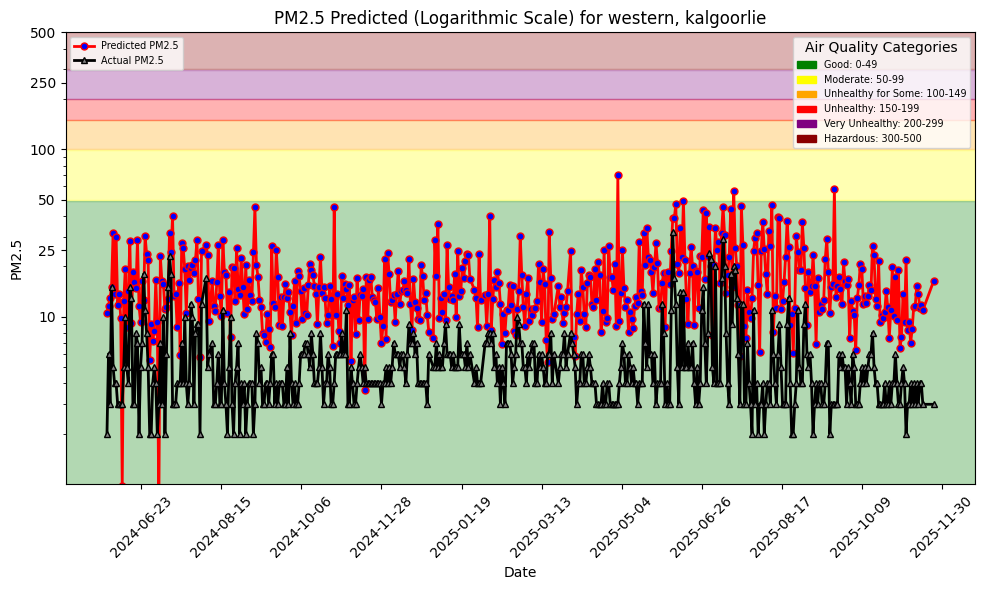

In [29]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

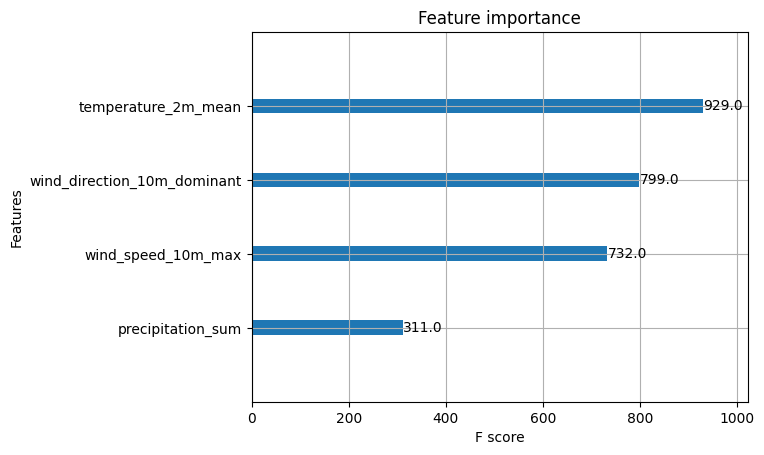

In [30]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [31]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/air_quality_xgboost_model.json")

In [32]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [33]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/air_quality_xg…

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/images/feature…

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hi…

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/model_schema.json: 0.000%|      …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279183/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
